# BFR clustering

## Preprocessing

In [ ]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE



df = pd.read_csv('songs.csv')
df.dtypes

C:\Users\Pezhman\AppData\Local\Temp\ipykernel_12756\2064255492.py:11: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('songs.csv')


danceability        float64
energy              float64
key                   int64
loudness            float64
mode                  int64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
type                 object
id                   object
uri                  object
track_href           object
analysis_url         object
duration_ms           int64
time_signature        int64
genre                object
song_name            object
Unnamed: 0          float64
title                object
dtype: object

### drop null and duplicated 

In [ ]:

columns_to_drop = ['type', 'id', 'uri', 'track_href','analysis_url', 'song_name' ] 
df = df.drop(columns=columns_to_drop)

duplicates = df[df.duplicated()]
df = df.drop_duplicates()

df.isna().sum()
missing_percent = df.isnull().mean() * 100
print(missing_percent)
df = df.drop(columns= ['Unnamed: 0', 'title'])

danceability         0.000000
energy               0.000000
key                  0.000000
loudness             0.000000
mode                 0.000000
speechiness          0.000000
acousticness         0.000000
instrumentalness     0.000000
liveness             0.000000
valence              0.000000
tempo                0.000000
duration_ms          0.000000
time_signature       0.000000
genre                0.000000
Unnamed: 0          50.319172
title               50.319172
dtype: float64


### normalize and drop target feature

In [6]:
df.value_counts('genre')

genre
Underground Rap    5771
Dark Trap          4518
trance             2999
trap               2987
techhouse          2975
dnb                2966
psytrance          2961
Hiphop             2960
techno             2956
hardstyle          2936
RnB                2039
Trap Metal         1897
Rap                1809
Emo                1601
Pop                 452
Name: count, dtype: int64

In [7]:
df['genre'].nunique()

15

In [8]:
df_up = df.drop(columns = ['genre'])

scaler = MinMaxScaler()
df_up = pd.DataFrame(scaler.fit_transform(df_up), columns=df_up.columns)
df_up.head()

danceability    energy       key  loudness  mode  speechiness  \
0      0.829884  0.813955  0.181818  0.712039   1.0     0.430304   
1      0.708527  0.492877  0.727273  0.715710   1.0     0.061410   
2      0.850471  0.892974  0.454545  0.782742   1.0     0.042890   
3      0.445227  0.780947  0.000000  0.784742   1.0     0.086971   
4      0.794127  0.623909  0.181818  0.703712   1.0     0.292754   

   acousticness  instrumentalness  liveness   valence     tempo  duration_ms  \
0      0.060525          0.013549  0.045943  0.382028  0.610006     0.111487   
1      0.405870          0.000000  0.109792  0.108635  0.351848     0.224043   
2      0.013967          0.000004  0.369692  0.021046  0.986200     0.082507   
3      0.023987          0.000000  0.105699  0.161250  0.794595     0.110497   
4      0.219635          0.000000  0.158907  0.590426  0.554579     0.110088   

   time_signature  
0            0.75  
1            0.75  
2            0.75  
3            0.50  
4            0.75

## BFR

In [9]:

class BFR:
    def __init__(self, n_clusters, threshold=1.0, max_iterations=100):

        self.n_clusters = n_clusters
        self.threshold = threshold
        self.max_iterations = max_iterations
        self.DS = {}  # Discard Set
        self.CS = []  # Compression Sets
        self.RS = []  # Retained Set
        self.iteration = 0  

    def initialize_clusters(self, data):
        kmeans = KMeans(n_clusters=self.n_clusters, init='k-means++', n_init=10)
        kmeans.fit(data)
        centers = kmeans.cluster_centers_
        self.DS = {i: {'N': 0, 'SUM': np.zeros(data.shape[1]), 'SUMSQ': np.zeros(data.shape[1])} for i in range(self.n_clusters)}

        self.cluster_assignments = []
        for point in data:
            cluster = np.argmin(np.linalg.norm(point - centers, axis=1))  
            self.update_DS(cluster, point)
            self.cluster_assignments.append(cluster)

    def update_DS(self, cluster, point):
        if cluster not in self.DS:
            self.DS[cluster] = {'N': 0, 'SUM': np.zeros(len(point)), 'SUMSQ': np.zeros(len(point))}
        self.DS[cluster]['N'] += 1
        self.DS[cluster]['SUM'] += point
        self.DS[cluster]['SUMSQ'] += point ** 2

    def assign_point(self, point):
        for cluster in self.DS:
            if self.mahalanobis_distance(cluster, point) < self.threshold:
                self.update_DS(cluster, point)
                return
        self.RS.append(point)

    def merge_RS_to_CS(self):
        new_RS = []
        for point in self.RS:
            merged = False
            for cs in self.CS:
                if self.mahalanobis_distance_to_CS(cs, point) < self.threshold:
                    self.update_CS(cs, point)
                    merged = True
                    break
            if not merged:
                new_RS.append(point)
        self.RS = new_RS  

    def update_CS(self, cs, point):
        cs['N'] += 1
        cs['SUM'] += point
        cs['SUMSQ'] += point ** 2

    def finalize_clusters(self):
        for cs in self.CS:
            cluster_id = len(self.DS)
            self.DS[cluster_id] = cs
        self.CS = []  

    def mahalanobis_distance(self, cluster, point):
        N = self.DS[cluster]['N']
        SUM = self.DS[cluster]['SUM']
        SUMSQ = self.DS[cluster]['SUMSQ']
        centroid = SUM / N
        variance = SUMSQ / N - centroid ** 2
        variance = np.maximum(variance, 1e-8)
        return np.sqrt(np.sum((point - centroid) ** 2 / variance))

    def mahalanobis_distance_to_CS(self, cs, point):
        N, SUM, SUMSQ = cs['N'], cs['SUM'], cs['SUMSQ']
        centroid = SUM / N
        variance = SUMSQ / N - centroid ** 2
        variance = np.maximum(variance, 1e-8)
        return np.sqrt(np.sum((point - centroid) ** 2 / variance))

    def fit(self, data):
        self.initialize_clusters(data)
        while self.iteration < self.max_iterations:
            prev_RS_size = len(self.RS)
            for point in data:
                self.assign_point(point)
            self.merge_RS_to_CS()
            self.iteration += 1

            if len(self.RS) == prev_RS_size:
                break

        self.finalize_clusters()
        return self.DS, self.cluster_assignments

## fitting BFR

In [10]:

bfr = BFR(n_clusters=15, threshold=1, max_iterations=10)
clusters, cluster_assignments = bfr.fit(df_up.values)
df['cluster'] = cluster_assignments

## cross tab and accuracy

In [14]:

crosstab = pd.crosstab(df['genre'], df['cluster'], margins=True, margins_name="Total")
print(crosstab)


correct_predictions = crosstab.apply(lambda row: row[:-1].max(), axis=1).sum()  
total_samples = crosstab.loc['Total', 'Total']  

accuracy = correct_predictions / total_samples
print(f"accuracy of clustering: {accuracy * 100:.2f}%")

cluster             0     1     2     3     4     5     6     7     8     9  \
genre                                                                         
Dark Trap         405   390   303   562   305   315   268   315   207   231   
Emo               347     2     2   232     5     1   205    98    72    74   
Hiphop            121    10     5   218     9     3   481   110   353   609   
Pop                33     0     1    26     1     3    64    17    71    73   
Rap                82     2     1   282     4     1   223    64   257   317   
RnB                87     6     0   188     2     1   271    54   312   281   
Trap Metal        305    19    20   458    35    12   263   106    79   132   
Underground Rap   333    13    18   863    38    24   927   194   621   848   
dnb               302   448   283   274   343   454    37   347    29    44   
hardstyle         477   130    74   348    85   100    34   759    39    53   
psytrance          24   631   892    27   642   521 

## TSNE

In [16]:

tsne = TSNE(n_components=2, random_state=42, perplexity=40, n_iter=750, n_jobs=-1)
data_2d = tsne.fit_transform(df_up)

df['tsne_x'] = data_2d[:, 0]
df['tsne_y'] = data_2d[:, 1]


d:\Users\Pezhman\AppData\Local\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


## plots

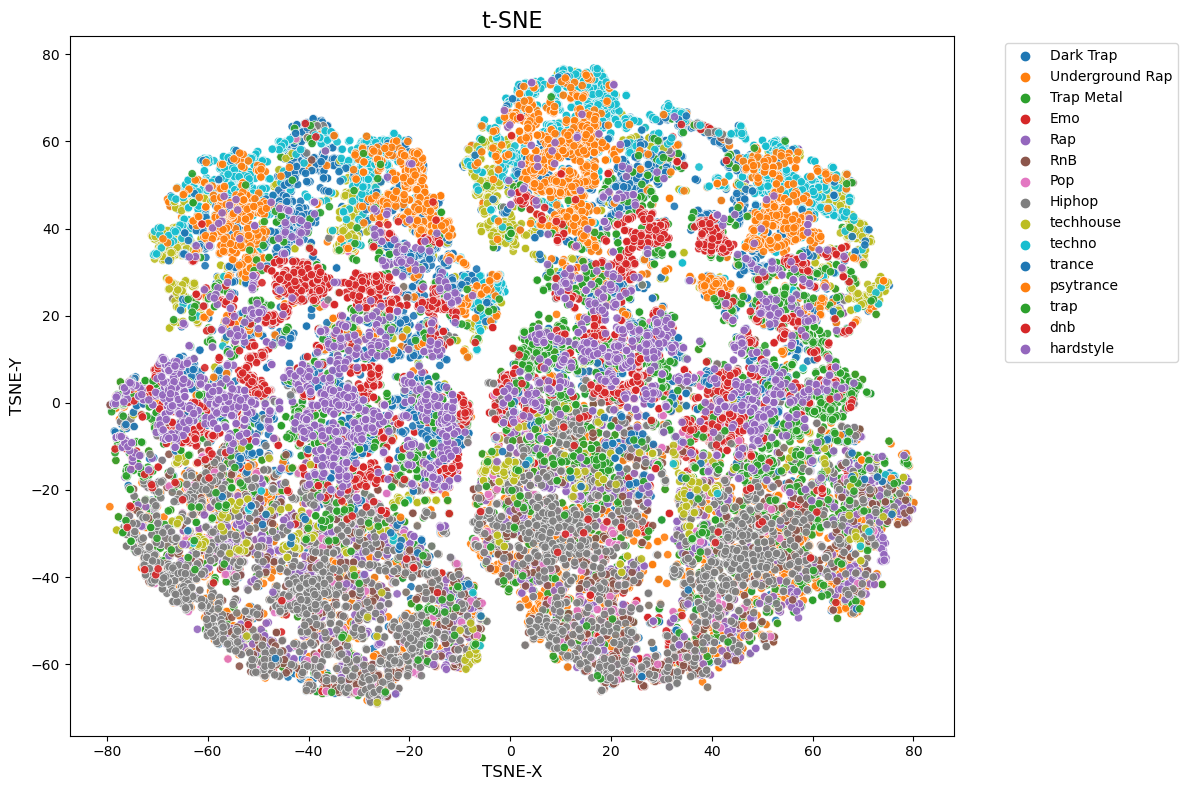

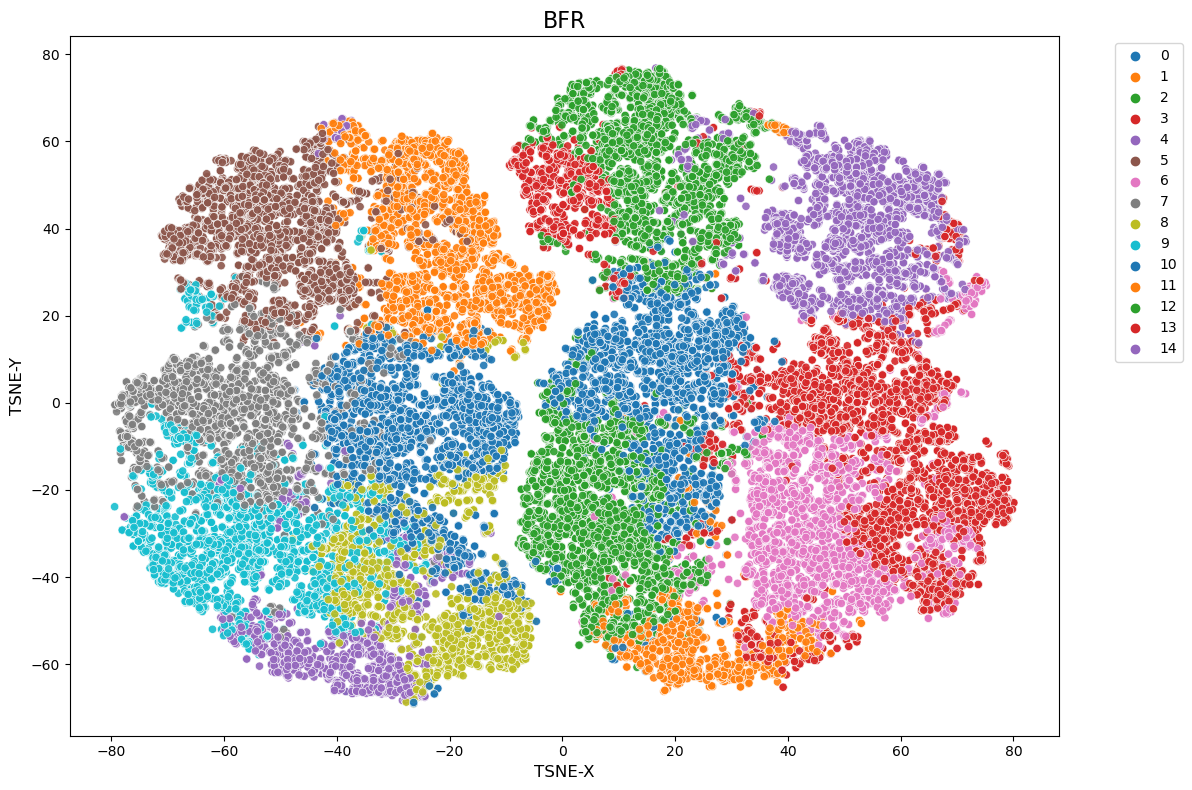

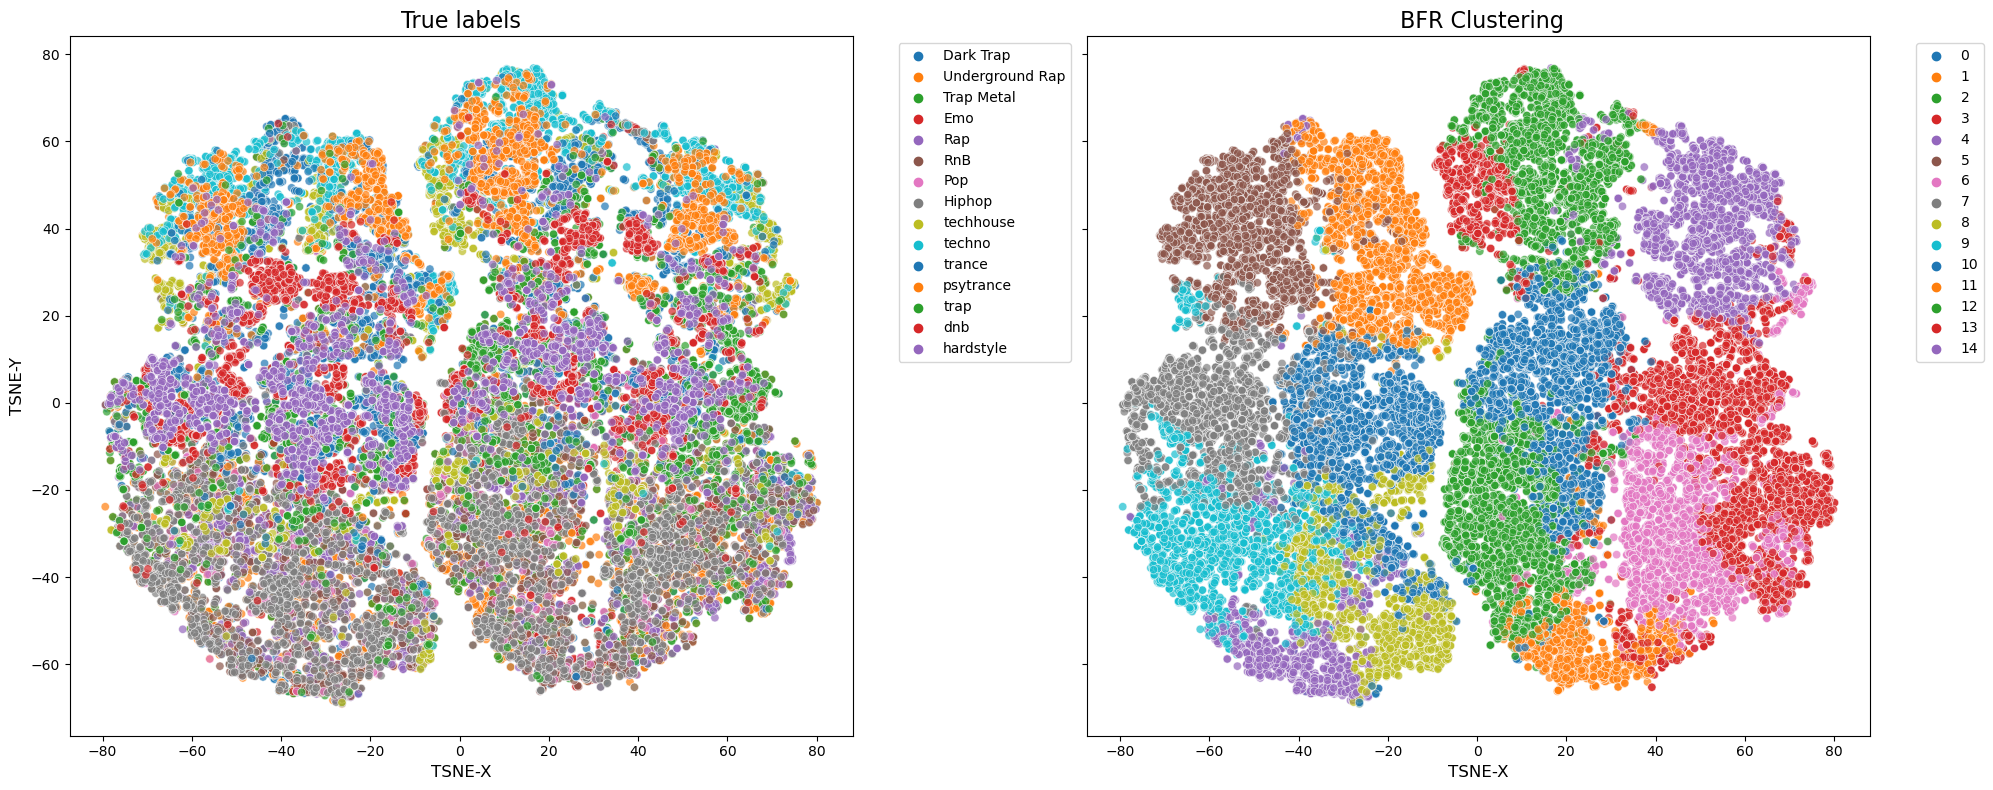

In [17]:

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne_x', y='tsne_y', hue='genre', data=df, palette='tab10', alpha=0.9
)
plt.title('t-SNE', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('TSNE-X', fontsize=12)
plt.ylabel('TSNE-Y', fontsize=12)
plt.tight_layout()
plt.show()



plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='tsne_x', y='tsne_y', hue='cluster', data=df, palette='tab10', alpha=0.9
)
plt.title('BFR', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel('TSNE-X', fontsize=12)
plt.ylabel('TSNE-Y', fontsize=12)
plt.tight_layout()
plt.show()



fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharex=True, sharey=True)

sns.scatterplot(
    x='tsne_x', y='tsne_y', hue='genre', data=df, palette='tab10', alpha=0.7, ax=axes[0]
)
axes[0].set_title('True labels', fontsize=16)
axes[0].set_xlabel('TSNE-X', fontsize=12)
axes[0].set_ylabel('TSNE-Y', fontsize=12)
axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

sns.scatterplot(
    x='tsne_x', y='tsne_y', hue='cluster', data=df, palette='tab10', alpha=0.7, ax=axes[1]
)
axes[1].set_title(' BFR Clustering', fontsize=16)
axes[1].set_xlabel('TSNE-X', fontsize=12)
axes[1].set_ylabel('TSNE-Y', fontsize=12)
axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()